In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from selenium import webdriver
import requests
import time
import re
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

### Mod Scraping

In [2]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--incognito")

driver = webdriver.Chrome()
driver.get('http://warframe.wikia.com/wiki/Mods_2.0')

In [3]:
headers = ['Warframe', 'Rifle', 'Shotgun', 'Pistol', 'Melee', 'Sentinel', 'Kubrow', 'Aura', 'Stance']
all_the_mods = []

#driver.find_elements_by_xpath('//*[@id="mw-content-text"]/div[30]/div/ul/li[%i]/a' % (i+1))[0].click()

for i, main_table in enumerate(BeautifulSoup(driver.page_source, 'html.parser').find_all('tbody')[6:9]):

    total_time = 0
    total_count = 0
    
    for row in main_table.find_all('tr'):
        start = time.clock()
        
        row_list = row.find_all('td')
        d = {
            'name' : row_list[0].text.strip(),
            'rarity' : row_list[3].text.strip(),
            'category' : row_list[4].text.strip(),
            'type' : headers[i]
            }
        
        response = requests.get('http://warframe.wikia.com'+row_list[0].find('a')['href'])
        
        mod_page = BeautifulSoup(response.text, 'html.parser').find('table', class_='emodtable')
        for first,last in zip(mod_page.find_all('tr')[0].find_all('th'), mod_page.find_all('tr')[-1].find_all('td')):
            d[first.text.strip().lower()] = last.text.strip()
            
        all_the_mods.append(d)
        time.sleep(1)
        
        total_time += time.clock() - start
        total_count += 1
        
    try:
        print('Now onto: ' + headers[i+1], '!')
        print('Average time per row of ' + headers[i], 'was %f.2 seconds' % (total_time / total_count))
        print(total_count, 'mods were scraped\n----------------------------------\n')
    except:
        print('Done!')
driver.close()

KeyboardInterrupt: 

In [ ]:
mod_df = pd.DataFrame(all_the_mods).fillna(0)
mod_df.sort_values(by='cost')
del mod_df['conclave']
print(mod_df.columns)
['magazine']

### Weapon Scraping

In [4]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--incognito")

driver = webdriver.Chrome()
driver.get('http://warframe.wikia.com/wiki/Weapon_Comparison')

body_docs = BeautifulSoup(driver.page_source, 'html.parser').find_all('tbody')

In [5]:
column_names = ['Name', 'Trigger_Type', 'Damage', 
                'Crit_Chance', 'Crit_Damage', 'Status_Chance', 
                'Projectile_Type', 'Fire_Rate', 'Magazine_Size', 
                'Reload_Time', 'MR', 'Disposition']
to_df = []
for row in body_docs[1].find_all('tr'):
    single_row = {}
    for i, tab_value in enumerate([a.text for a in row.find_all('td')]):
        if i == 2:
            single_row[column_names[i]] = float(re.search(r'(\d+\.?\d?)', tab_value[-10:]).group(1))
            continue
        if i == 11:
            single_row[column_names[i]] = int(re.search(r'Disposition(\d)\.png', tab_value).group(1))
            continue
        single_row[column_names[i]] = tab_value
    to_df.append(single_row)
df = pd.DataFrame(to_df)

     Crit_Chance  Crit_Damage  Damage  Disposition  Fire_Rate  MR  \
0           50.0          2.0     7.5            3      20.00   5   
1           22.0          1.6   600.0            3       1.10  10   
2            9.0          1.5    57.0            3       4.33   7   
3           17.0          1.9   190.0            4       4.33   7   
4           25.0          2.0   125.0            5       3.67   0   
5           26.0          2.8    16.0            3      16.67   7   
6           10.0          1.5   176.0            5       4.17   2   
7           15.0          2.0   184.0            5       4.67   2   
8            5.0          1.5    25.0            2       8.75   2   
9            5.0          2.0    55.0            2      10.00   2   
10          10.0          1.5    20.0            3       8.75   0   
11          10.0          2.0    35.0            3       9.58   0   
12          10.0          2.0    35.0            3       7.50   0   
13           5.0          1.5    3

### DF Cleaning
The following, simplistic, damage calculation was used to quickly analyze disposition.  A more robust damage metric is necessary for a more realistic analysis.

$$DPS = \text{Fire_Rate}\left(\frac{\text{Crit_Chance}}{100} * \text{Crit_Damage} * \text{Base_Damage} + \frac{\text{100 - Crit_Chance}}{100} * \text{Base_Damage}\right)$$

In [ ]:
df['Crit_Chance'] = df['Crit_Chance'].apply(lambda x: float(x[:-1]))
df['Crit_Damage'] = df['Crit_Damage'].apply(lambda x: float(x[:-1]))
df['Status_Chance'] = df['Status_Chance'].apply(lambda x: float(x[:-1]))
df['Reload_Time'] = df['Reload_Time'].apply(lambda x: float(x[:-2]))
df['Damage'] = df['Damage'].apply(lambda x: float(x))
df['Fire_Rate'] = df['Fire_Rate'].apply(lambda x: float(x))

df['DPS'] = df.apply(lambda x: (x['Crit_Chance']/100.0 * x['Crit_Damage'] * x['Damage'] 
                                + (100.0 - x['Crit_Chance'])/100.0 * x['Damage']) * x['Fire_Rate'], axis=1)   
print(df)

### Primary Weapon Visualization

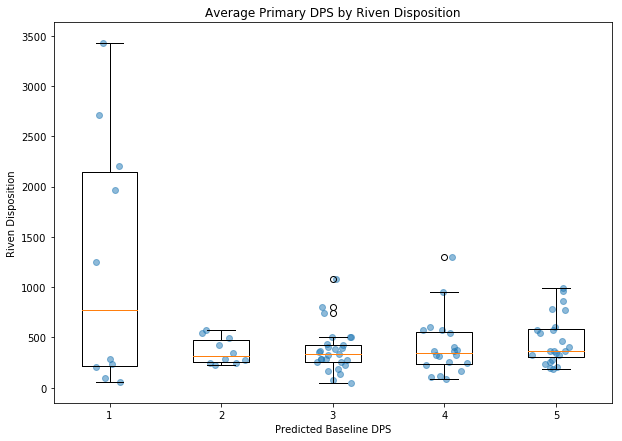

In [6]:
df = df[df.DPS > 0.0]

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.boxplot([df.loc[df['Disposition'] == i, 'DPS'] for i in range(1,6)])
x_jitter = np.array(df['Disposition']) + np.random.normal(loc = 0.0, scale = 0.1, size = len(df['Disposition']))
ax.scatter(x_jitter, df['DPS'], alpha = 0.5)
ax.set_title('Average Primary DPS by Riven Disposition')
ax.set_xlabel('Predicted Baseline DPS')
ax.set_ylabel('Riven Disposition')
plt.show()

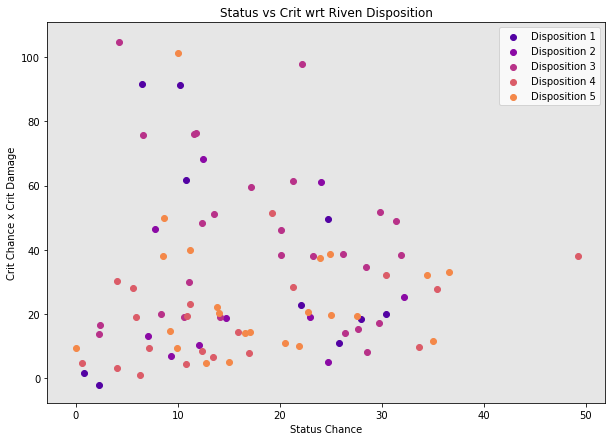

In [7]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
n = len(df)
x_sc = df['Status_Chance'] + np.random.normal(loc = 0.0, scale = 2.0, size = n)
y_crit = np.multiply(df['Crit_Chance'], df['Crit_Damage']) + np.random.normal(loc = 0.0, scale = 2.0, size = n)

colors = cm.get_cmap('plasma', 8)

for i in range(1,6):
    ax.scatter(x_sc[df['Disposition']==i], y_crit[df['Disposition']==i], c = colors(i), label = 'Disposition ' + str(i))
ax.legend()
ax.set_facecolor((0.9, 0.9, 0.9))
ax.set_ylabel('Crit Chance x Crit Damage')
ax.set_xlabel('Status Chance')
ax.set_title('Status vs Crit wrt Riven Disposition')

In [15]:

df.loc[(y_crit > 95)&(x_sc < 20), 'Name']

46       Lenz
84    Synapse
Name: Name, dtype: object